In [ ]:
!pip install -U tqdm gdown

In [2]:
import os
import shutil
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import VGG16_Weights
from tqdm.auto import tqdm

print('Dependencies loaded.')

print("===================================================")
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime!')
print("===================================================")

Dependencies loaded.
Cuda available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total memory: 6.0 GB


In [3]:
# Dataset Download
ID = '1wYzBpucuU_RPMebUrWi2TH3Mfz-ykBGl'
output = 'Dataset.zip'

datasetDirectory = "Dataset"
if not (os.path.exists(datasetDirectory)):
  os.makedirs(datasetDirectory)

# dataset_url = 'https://drive.google.com/uc?id=' + ID + '&export=download&confirm=t'
# gdown.download(dataset_url, output, quiet=False)

with zipfile.ZipFile(output) as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, datasetDirectory)
        except zipfile.error as e:
            pass

print('Deleting the previous downloaded zip.')
os.remove('Dataset.zip')
print('Done.')

Extracting :   0%|          | 0/567713 [00:00<?, ?it/s]

Deleting the previous downloaded zip.
Done.


In [28]:
model = models.vgg16(weights=VGG16_Weights.DEFAULT)

# Replace the last fully connected layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # 2 for binary classification

In [29]:
for name, param in model.named_parameters():
    if name.startswith("classifier"):
        param.requires_grad=True
    if name.startswith("features"):
       if int(name.split(".")[1])>=24:     
            param.requires_grad=True
       else:
           param.requires_grad=False
    
    # Print the requires_grad property for each parameter
    print(f"Parameter: {name} | Requires grad: {param.requires_grad}")    

model = model.to(device)

Parameter: features.0.weight | Requires grad: False
Parameter: features.0.bias | Requires grad: False
Parameter: features.2.weight | Requires grad: False
Parameter: features.2.bias | Requires grad: False
Parameter: features.5.weight | Requires grad: False
Parameter: features.5.bias | Requires grad: False
Parameter: features.7.weight | Requires grad: False
Parameter: features.7.bias | Requires grad: False
Parameter: features.10.weight | Requires grad: False
Parameter: features.10.bias | Requires grad: False
Parameter: features.12.weight | Requires grad: False
Parameter: features.12.bias | Requires grad: False
Parameter: features.14.weight | Requires grad: False
Parameter: features.14.bias | Requires grad: False
Parameter: features.17.weight | Requires grad: False
Parameter: features.17.bias | Requires grad: False
Parameter: features.19.weight | Requires grad: False
Parameter: features.19.bias | Requires grad: False
Parameter: features.21.weight | Requires grad: False
Parameter: features

In [30]:
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Optimizer for training the last layer
epochs = 2

Training feature shape : torch.Size([64, 3, 286, 286])
Training labels shape  : torch.Size([64])
----------------------------------------------
Test feature shape     : torch.Size([64, 3, 384, 384])
Test labels shape      : torch.Size([64])


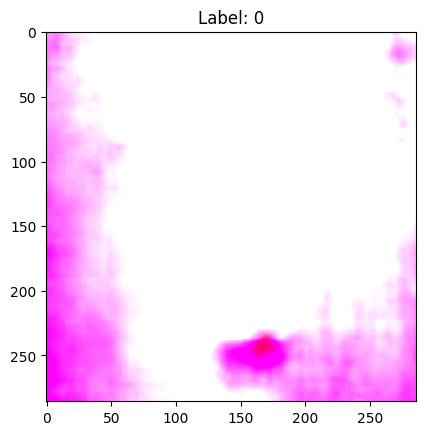

In [31]:
# Define data transformations
transformTrain = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.CenterCrop(286),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformsTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths for train_dir and test_dir according to split perfomed on OFs dataset
train_dir = os.path.join("Dataset", "train")
test_dir = os.path.join("Dataset", "test")

# Load the custom dataset
train_dataset = ImageFolder(root=train_dir, transform=transformTrain)
test_dataset = ImageFolder(root=test_dir, transform=transformsTest)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Dataloaders
train_features, train_labels = next(iter(train_loader))
print("===================================================")
print(f"Training feature shape : {train_features.size()}")
print(f"Training labels shape  : {train_labels.size()}")
print('----------------------------------------------')
test_features, test_labels = next(iter(test_loader))
print(f"Test feature shape     : {test_features.size()}")
print(f"Test labels shape      : {test_labels.size()}")
print("===================================================")

image = train_features[0]
plt.imshow(image.permute(1,2,0).clamp(0,1))
plt.title(F"Label: {train_labels[0]}")
plt.show()

In [32]:
trainLosses = []
trainAccuracies = []
valLosses = []
valAccuracies = []

bestAcc = 0

for epoch in range(1, epochs+1):
    # Training loop
    model.train()
    totalTrain = 0
    correctTrain = 0

    with tqdm(total=len(train_loader), desc=F'Epoch {epoch}/{epochs+1} | Training') as pbar:
        for i, data in enumerate(train_loader):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            lTrain = criterion(outputs, labels)

            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            totalTrain += labels.size(0)
            correctTrain += (predicted == labels).sum().item()

            # Backward and optimize
            optimizer.zero_grad()
            lTrain.backward()
            optimizer.step()
            pbar.update()

    # Evaluation
    model.eval()
    with torch.no_grad():
        correctVal = 0
        totalVal = 0
        with tqdm(total=len(test_loader), desc=F'Epoch {epoch}/{epochs+1} | Test') as pbar:
            for i, data in enumerate(test_loader):
                images, labels = data

                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                lVal = criterion(outputs, labels)

                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                totalVal += labels.size(0)
                correctVal += (predicted == labels).sum().item()
                pbar.update()
            
    # Losses computation
    train_loss_epoch = lTrain.item()
    val_loss_epoch = lVal.item()
    trainLosses.append(train_loss_epoch)
    valLosses.append(val_loss_epoch)
    
    # Accuracies computation
    val_acc_epoch = correctVal / totalVal
    train_acc_epoch = correctTrain / totalTrain
    trainAccuracies.append(train_acc_epoch)
    valAccuracies.append(val_acc_epoch)

    if(val_acc_epoch > bestAcc):
        previousBestAcc = bestAcc
        bestAcc = val_acc_epoch
        print("\nVal Accuracy increased at epoch {}: {:.5f} --> {:.5f} | Saving model..".format(epoch, previousBestAcc, bestAcc))
        torch.save(model, F"vgg16_epoch-{epoch}_accT-{train_acc_epoch:.5f}_accV-{bestAcc:.5f}.pt")

    print('\nEpoch {}/{}:\n\tTrain Acc: {:.3f} (avg. {:.3f}) | Train Loss: {:.3f} (avg. {:.3f}) | \
        \n\tVal Acc  : {:.3f} (avg. {:.3f}) | Val Loss: {:.3f} (avg. {:.3f}) |'.format(epoch, epochs, 
                                                                                    train_acc_epoch*100,
                                                                                    np.average(trainAccuracies)*100,  
                                                                                    train_loss_epoch,
                                                                                    np.average(trainLosses),
                                                                                    val_acc_epoch*100,
                                                                                    np.average(valAccuracies)*100,
                                                                                    val_loss_epoch,
                                                                                    np.average(valLosses)))
    print("=========================================")

Epoch 1/11 | Training:   0%|          | 0/7097 [00:00<?, ?it/s]

KeyboardInterrupt: 